# Empirically Matching OM10 Lens Galaxies to SL2S

_Phil Marshall & Bryce Kalmbach, September 2016_

We need to be able to assign a stellar mass and size to each of our OM10 lens galaxies, so that we can, in turn, associate a suitable `CatSim` galaxy (with appropriate SED) with that object. To do this, we will follow Tom Holoien's "empiriciSN" approach, and model the intrinsic distribution of lens galaxy size, stellar mass, redshift and velocity dispersion with the "extreme deconvolution" algorithm.


## Requirements

You will need to have installed Tom Holoien's [`XDGMM`]() and [`empiriciSN`]() packages, as well as their dependencies. 

> By default, in `empiricSN` all the model fitting is done with the [`AstroML`](http://www.astroml.org/index.html) XDGMM algorithm rather than the [Bovy et al. (2011)](https://github.com/jobovy/extreme-deconvolution) algorithm - for this demo you do not need to have the Bovy et al. algorithm installed to run the code. However, we note that the Bovy et al. algorithm is, in general, significantly (i.e., several times) faster. We recommend you try each method on your dataset when using this class.

** _Warning: this notebook is incomplete, having been copied and hacked from the empiriciSN demo..._ **

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import corner
import urllib
import os
from sklearn.cross_validation import train_test_split
from astroML.plotting import setup_text_plots

import empiriciSN
from MatchingLensGalaxies_utilities import *

/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Empirical Strong Lens Data

We'll use the SL2S sample of galaxy-scale lenses to model the properties of OM10 lenses. The redshifts and velocity dispersions should cover *most* (but not all) of the LSST lensed quasar sample in OM10.

The data is in Table 3 of [Sonnenfeld et al (2013)](https://arxiv.org/abs/1307.4759), and stored as a csv format file in the Twinkles data folder. (TBC!)

In [2]:
def get_sl2s_data():
    filename = '../../data/SonnenfeldEtal2013_Table3.csv'
    ! wc -l $filename

    z = np.array([])
    z_err = np.array([])
    v_disp = np.array([])
    v_disp_err = np.array([])
    r_eff = np.array([])
    r_eff_err = np.array([])
    log_m = np.array([])
    log_m_err = np.array([])
    
    infile = open(filename, 'r')
    inlines = infile.readlines()
    
    for line1 in inlines:
        if line1[0] == '#': continue
        line = line1.split(',')
        
        #Params
        z = np.append(z, float(line[1]))
        v_disp = np.append(v_disp, float(line[2]))
        r_eff = np.append(r_eff, float(line[3]))
        log_m = np.append(log_m, float(line[4]))
        
        #Errors
        z_err = np.append(z_err, float(line[5]))
        v_disp_err = np.append(v_disp_err, float(line[6]))
        r_eff_err = np.append(r_eff_err, float(line[7]))
        log_m_err = np.append(log_m_err, float(line[8]))
    
    #Build final arrays
    X = np.vstack([z, v_disp, r_eff, log_m]).T
    Xerr = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    
    Xerr[:, diag, diag] = np.vstack([z_err**2, v_disp_err**2,
                                    r_eff_err**2, log_m_err**2]).T
    
    return X, Xerr

# Here's what we did to get the csv file:
# ! echo "ID, zlens, vdisp, Reff, Mstar, zlens_err, vdisp_err, Reff_err, Mstar_err" > SonnenfeldEtal2013_Table3.csv  
# ! cat gammaptable.tex | sed s%'&'%%g | sed s%'\$'%%g | sed s%'\\'%%g | sed s%'pm'%'  '%g | sed s%'disky'%%g | awk '{print $1", "$2", "$5", "$3", "$7", 0.001, "$6", 0.01, "$8}' >> SonnenfeldEtal2013_Table3.csv

## Component Test

We could fit our lens galaxy dataset directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. Knowing the optimal number of components to fit allows us to obtain a good fit in the smallest amount of time without overfitting the data.

### BIC
One way to determine the optimal number of Gaussian components to use in the model is by fitting the model with different numbers of components and calculating the Bayesian information criterion (BIC) for each model. The BIC incorporates the number of components in the model, the sample size, and the likelihood of the data under the model, and the model with the lowest score is the optimal model to use.

We can test for the model with the lowest BIC score for a given dataset using the `component_test` function, which will compute the BIC for a given dataset and range of n_components and return an array containing all the BIC scores as well as the optimal number of components and corresponding BIC value. The code below will read in all the SN and host parameters we want to use from our data files (using the `get_data` function) and use these data to test the performance of the model with n_components ranging from 1 to 8. (Larger numbers of components tend to run into errors occurring because too few observations map to a given Gaussian component. With a bigger dataset, this range could be increased.)

<Note that due to the multiple fits and the large dataset, the BIC test will likely take a while to run, depending on your system.>

In [3]:
# Instantiate an empiriciSN worker object:
empiricist = empiriciSN.Empiricist()

In [4]:
# Define the range of component numbers and read in the dataset:
component_range = np.array([1,2,3,4,5,6,7,8])
X, Xerr = get_sl2s_data()

      26 ../../data/SonnenfeldEtal2013_Table3.csv


In [5]:
# Loop over component numbers, fitting XDGMM model and computing the BIC. 

bics, optimal_n_comp, lowest_bic = empiricist.component_test(X, Xerr, component_range)

/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

N = 1 , BIC = 404.677168861


/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

N = 2 , BIC = 410.426768575


/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

N = 3 , BIC = 442.266672909


/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

N = 4 , BIC = 453.721342968


/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

N = 5 , BIC = 482.676598861


/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

N = 6 , BIC = 496.589169764


/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

N = 7 , BIC = 516.102288146


/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

N = 8 , BIC = 549.019699858


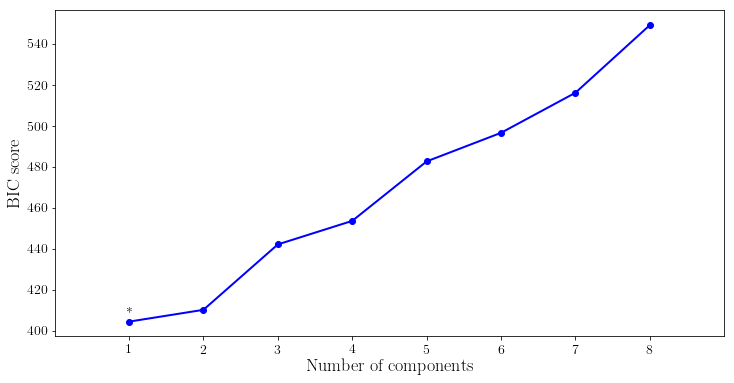

In [6]:
plot_bic(component_range, bics, optimal_n_comp)

> Based on the results of the above test, the model with 1 component has the lowest BIC score and is the optimal choice.


## Fitting a Model

Once we know how many components to use in the model, we can fit a model using that number of components using the `fit_model` function. Before fitting for this demo, we are going to split our lens galaxy dataset 65-35, with the larger subsample being used to fit the model and the smaller subsample providing a test sample that we can use to predict stellar masses and compare with our predicted sample.

In [7]:
# Split the dataset 65/35:
X_train, X_test, Xerr_train, Xerr_test = \
    train_test_split(X, Xerr, test_size=0.35, random_state=17)

# Fit the model:
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=1)
#empiricist.read_model('demo_model.fit')

/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

Note how the `fit_model` function also saves the fit to a file for later re-use. If a model has already been fit, it can be read into an existing `Empiricist` worker, or a new `Empiricist` can be instantiated using the model, like this:

In [8]:
alternative = empiriciSN.Empiricist(model_file='demo_model.fit')

# Print the weights array for each object---they should be the same...
print empiricist.XDGMM.weights
print alternative.XDGMM.weights

[ 1.]
[ 1.]


## Predicting stellar masses of lens galaxies

Our goal in this notebook is to predict the stellar masses of OM10 lens galaxies. Here we use the XDGMM model we just fit on the test data we separated off from the full dataset. We will use the model to predict stellar masses of lens galaxies based upon their redshift, velocity dispersion and radial size.

<The "test" sample generated above gives us a set of 482 host properties that we can use to fit supernovae, and a set of supernova properties to compare with our model fits.>

First, we adapt the "get_logR" function from empiriciSN to "get_log_m" changing the references and restrictions of that method (it only allows certain columns due to structure of SN dataset it uses) to suit our strong lensing dataset.

In [9]:
#Write new conditioning function
def get_log_m(cond_indices, m_index, X, model_file, Xerr=None):
    
    """
        Uses a subset of parameters in the given data to condition the
        model and return a sample value for log(M/M_sun).

        Parameters
        ----------
        cond_indices: array_like
            Array of indices indicating which parameters to use to
            condition the model. 
        m_index: int
            Index of log(M/M_sun) in the list of parameters that were used
            to fit the model.
        X: array_like, shape = (n < n_features,)
            Input data.
        Xerr: array_like, shape = (X.shape,) (optional)
            Error on input data. If none, no error used to condition.

        Returns
        -------
        log_m: float
            Sample value of log(M/M_sun) taken from the conditioned model.

        Notes
        -----
        The fit_params array specifies a list of indices to use to
        condition the model. The model will be conditioned and then
        a mass will be drawn from the conditioned model.

        This is so that the mass can be used to find CATSIM galaxies
        to act as hosts for OM10 systems.

        This does not make assumptions about what parameters are being
        used in the model, but does assume that the model has been
        fit already.
    """

    if m_index in cond_indices:
        raise ValueError("Cannot condition model on log(M/M_sun).")

    cond_data = np.array([])
    if Xerr is not None: cond_err = np.array([])
    m_cond_idx = m_index
    n_features = empiricist.XDGMM.mu.shape[1]
    j = 0

    for i in range(n_features):
        if i in cond_indices:
            cond_data = np.append(cond_data,X[j])
            if Xerr is not None: cond_err = np.append(cond_err, Xerr[j])
            j += 1
            if i < m_index: m_cond_idx -= 1
        else:
            cond_data = np.append(cond_data,np.nan)
            if Xerr is not None: cond_err = np.append(cond_err, 0.0)

    if Xerr is not None:
        cond_XDGMM = empiricist.XDGMM.condition(cond_data, cond_err)
    else: cond_XDGMM = empiricist.XDGMM.condition(cond_data)

    sample = cond_XDGMM.sample()
    log_m = sample[0][m_cond_idx]
    return log_m

With that ready to go, we now use it to get estimates on the stellar mass of our test data from the model we have trained above.

In [10]:
# Get actual masses from dataset, for comparison:
log_m_test = X_test[:,3]
r_test = X_test[:,2]

# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
sample_log_m = np.array([])
sample_r = np.array([])

model_file='demo_model.fit'

for x, xerr in zip(X_test, Xerr_test):
    log_m = get_log_m(cond_indices, 3, x[cond_indices], model_file)#, Xerr=xerr)
    sample_log_m = np.append(sample_log_m,log_m)
    print x[3], log_m
    
for x, xerr in zip(X_test, Xerr_test):
    r_cond = get_log_m(cond_indices, 2, x[cond_indices], model_file)#, Xerr=xerr)
    sample_r = np.append(sample_r,r_cond)
    print x[2], r_cond

11.76 11.331095751
11.45 11.4383623875
11.6 11.472890811
11.28 11.1648297715
11.81 11.2007569882
11.14 11.4886673289
11.26 11.4436672157
11.51 12.2439183667
11.53 11.7600296547
7.86 6.25885282711
8.92 8.05264143642
4.35 13.7363710186
3.04 3.37140361718
8.59 4.61904829769
1.35 0.586960021396
3.86 7.39634635567
3.93 7.89501023704
4.27 12.8430002306


Now we have a set of test masses in units of log(M/M_sun) and a set of masses sampled from the model. These should have the same distribution when plotted.

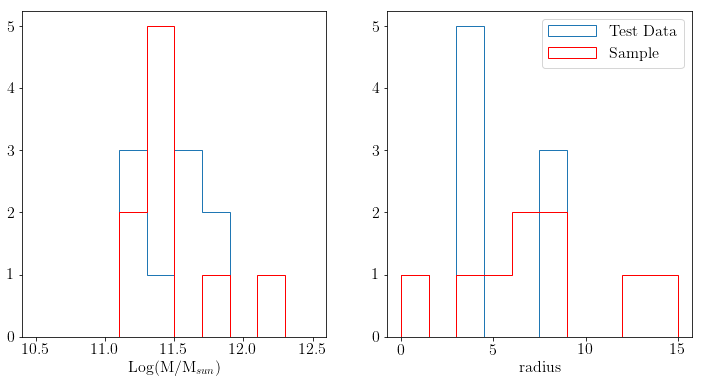

In [11]:
fig = plt.figure(figsize=(12,6))

fig.add_subplot(121)
plt.hist(log_m_test, 10, range=(10.5, 12.5), histtype='step')
plt.hist(sample_log_m, 10, range=(10.5, 12.5), color ='r', histtype='step')
plt.xlabel(r'Log(M/M_{sun})')

fig.add_subplot(122)
plt.hist(r_test, 10, range=(0, 15), histtype='step')
plt.hist(sample_r, 10, range=(0, 15), color ='r', histtype='step')
plt.xlabel('radius')
plt.legend(('Test Data', 'Sample'))
plt.show()

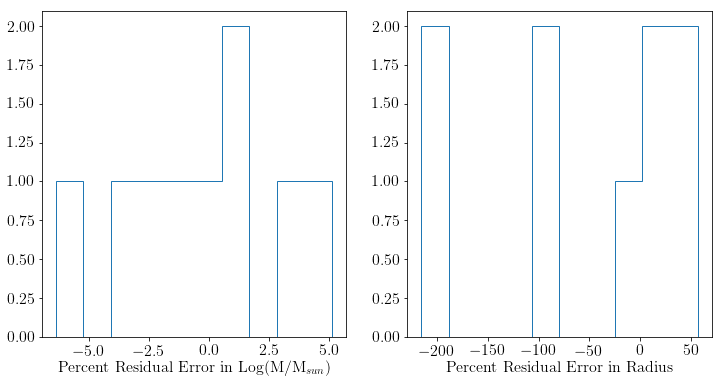

In [12]:
fig = plt.figure(figsize=(12,6))

fig.add_subplot(121)
plt.hist(100*(log_m_test-sample_log_m)/log_m_test, 10, histtype='step')
plt.xlabel(r'Percent Residual Error in Log(M/M_{sun})')

fig.add_subplot(122)
plt.hist(100*(r_test-sample_r)/r_test, 10, histtype='step')
plt.xlabel('Percent Residual Error in Radius')

It seems that while we can predict the stellar masses to a reasonable degree the estimates for Radius are very poor and we should get those values from CATSIM while matching galaxies on just stellar mass, redshift and ellipticity.

We want to make sure that the model gives reasonable values when generating masses, redshift and velocity dispersions. Therefore, we will sample the GMM and plot against the test data.

In [13]:
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=1)
test_sample = empiricist.XDGMM.sample(size=10000)

/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

/Users/Bryce/miniconda2/lib/python2.7/site-packages/matplotlib/cbook.py:2641: UserWarning: Saw kwargs [u'ms', u'markersize'] which are all aliases for u'markersize'.  Kept value from u'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


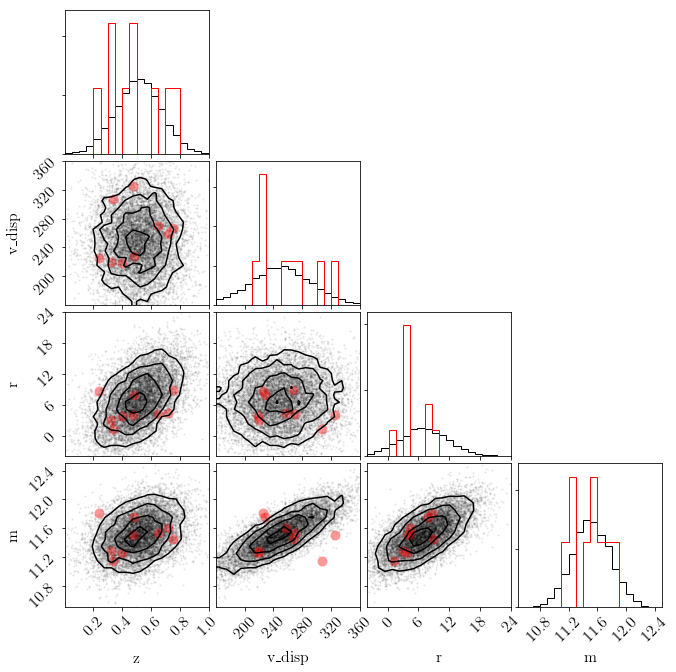

In [14]:
setup_text_plots(fontsize=16, usetex=True)

figure = corner.corner(test_sample[:,:], labels=['z', 'v\_disp', 'r', 'm'], 
                       range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X_test[:, :], labels=['z', 'v\_disp', 'r', 'm'], color='red', 
              range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)
plt.show()

Here we try fitting our model with 2 components in the GMM.

In [15]:
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=2)

/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

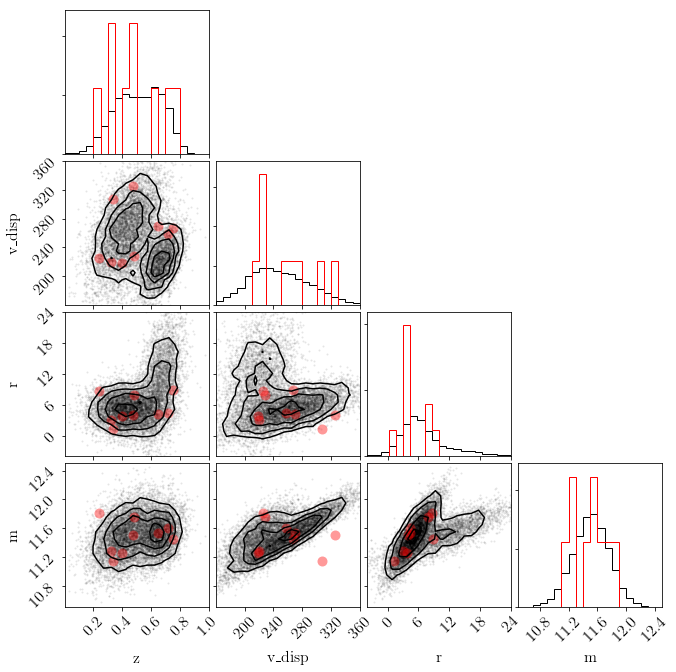

In [16]:
test_sample = empiricist.XDGMM.sample(size=10000)
setup_text_plots(fontsize=16, usetex=True)

figure = corner.corner(test_sample[:,:], labels=['z', 'v\_disp', 'r', 'm'], 
                       range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X_test[:, :], labels=['z', 'v\_disp', 'r', 'm'], color='red', 
              range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)
plt.show()

And here we use 3 components.

In [17]:
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=3)

/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

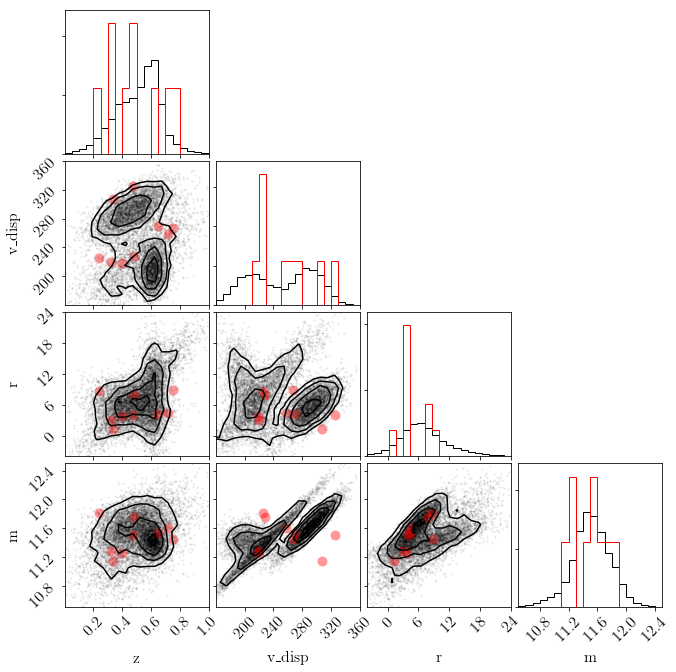

In [18]:
test_sample = empiricist.XDGMM.sample(size=10000)
setup_text_plots(fontsize=16, usetex=True)

figure = corner.corner(test_sample[:,:], labels=['z', 'v\_disp', 'r', 'm'], 
                       range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X_test[:, :], labels=['z', 'v\_disp', 'r', 'm'], color='red', 
              range = [(0.0, 1.0), (160, 360), (-4, 24), (10.5, 12.5)],
              hist_kwargs = {'normed':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)
plt.show()

In [19]:
#### Once above is correct we will bring in OM10 systems.

### Estimating Stellar Masses for SN systems

We have decided to move forward with the 1-parameter GMM model and will now use the available data in SN sytems to find a stellar mass for SN systems based upon redshift and velocity dispersion. Since our attempts to predict radius seem to be inaccurate we will get radius estimate from CATSIM galaxies as well and thus only will be predicting stellar masses for SN lenses here.

In [20]:
# First load in OM10 lenses we are using in Twinkles

import pandas as pd
df = pd.read_csv('../../data/v1_sne_cat.csv')
system_rows = []
unique_systems = []
for sys_num in np.unique(df['twinkles_sysno']):
    system_rows.append(np.where(df['twinkles_sysno'] == sys_num)[0])
    unique_systems.append(system_rows[-1][0])

In [21]:
unique_df = df.iloc[unique_systems]

In [22]:
# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m = np.array([])
twinkles_reff = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=1)
twinkles_data = np.array([unique_df['zl'], unique_df['sigma']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 3, x[cond_indices], model_file)
    twinkles_log_m = np.append(twinkles_log_m,log_m)
    
#for x in twinkles_data:
#    r_eff = get_log_m(cond_indices, 2, x[cond_indices], model_file)
#    twinkles_reff = np.append(twinkles_reff, r_eff)

/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

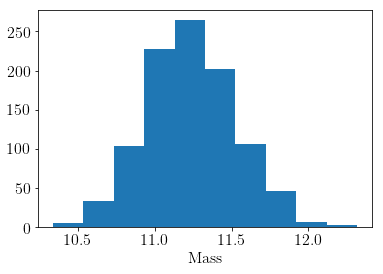

In [23]:
#fig = plt.figure(figsize=(12,6))
#fig.add_subplot(121)
plt.hist(twinkles_log_m)
plt.xlabel('Mass')
#fig.add_subplot(122)
#plt.hist(twinkles_reff)

Now we connect to the CATSIM database and use redshift, stellar_mass and ellipticity of our OM10 galaxies to find associated SED filenames and radial sizes for our galaxies. There are three queries of CATSIM possible based upon how good of a match is available. The first query looks for any galaxies within 10% in redshift, stellar mass and ellipticity. If no matches are found then it will look for galaxies within 10% in redshift and stellar mass only. Finally, if this is unavailable, it will extend the matching to 20%. At the 20% boundary we are able to match nearly 90% of the OM10 systems to a CATSIM galaxy.

In [24]:
from lsst.sims.catalogs.db import DBObject

In [29]:
db_obj = DBObject(database='LSSTCATSIM', host='localhost', port=51433,
                             driver='mssql+pymssql')

In [26]:
def query_catsim(dbo, redshift, m_star, ellip):
    
    dtype = np.dtype([('redshift', np.float),
                      ('mass_stellar', np.float),
                      ('a_b', np.float),
                      ('b_b', np.float),
                      ('sedname_bulge', str, 300)])
    query = """select redshift, mass_stellar, a_b, b_b, sedname_bulge
               from galaxy
               where redshift < %f and redshift > %f and sedname_bulge is not Null
                   and mass_stellar < %f and mass_stellar > %f 
                   and 1-(b_b/a_b) < %f and 1-(b_b/a_b) > %f""" % (redshift*1.1, redshift*.9, m_star*1.1, m_star*.9, 
                                                                   ellip*1.1, ellip*.9)
    results = dbo.execute_arbitrary(query, dtype=dtype)
        
    if len(results) > 0:
        return results
    else:
            query = """select redshift, mass_stellar, a_b, b_b, sedname_bulge
                       from galaxy
                       where redshift < %f and redshift > %f and sedname_bulge is not Null
                            and mass_stellar < %f and mass_stellar > %f """ % (redshift*1.1, redshift*.9, m_star*1.1, m_star*.9)
    results = dbo.execute_arbitrary(query, dtype=dtype)
        
    if len(results) > 0:
        return results
    else:
            query = """select redshift, mass_stellar, a_b, b_b, sedname_bulge
                       from galaxy
                       where redshift < %f and redshift > %f and sedname_bulge is not Null
                            and mass_stellar < %f and mass_stellar > %f """ % (redshift*1.2, redshift*.8, m_star*1.2, m_star*.8)
    results = dbo.execute_arbitrary(query, dtype=dtype)
    
    return results

In [27]:
def query_catsim(dbo, redshift, m_star, ellip):
    
    dtype = np.dtype([('redshift', np.float),
                      ('mass_stellar', np.float),
                      ('a_b', np.float),
                      ('b_b', np.float),
                      ('magnorm_bulge', np.float),
                      ('sedname_bulge', str, 300)])
    query = """select redshift, mass_stellar, a_b, b_b, magnorm_bulge, sedname_bulge
               from galaxy
               where redshift < %f and redshift > %f and sedname_bulge is not Null
                   and mass_stellar < %f and mass_stellar > %f 
                   and 1-(b_b/a_b) < %f and 1-(b_b/a_b) > %f and magnorm_bulge < 28.""" % (redshift*1.1, redshift*.9, m_star*1.1, m_star*.9, 
                                                                   ellip*1.1, ellip*.9)
    results = dbo.execute_arbitrary(query, dtype=dtype)
        
    if len(results) > 0:
        return results
    else:
            query = """select redshift, mass_stellar, a_b, b_b, magnorm_bulge, sedname_bulge
                       from galaxy
                       where redshift < %f and redshift > %f and sedname_bulge is not Null
                            and mass_stellar < %f and mass_stellar > %f and magnorm_bulge < 28.""" % (redshift*1.1, redshift*.9, m_star*1.1, m_star*.9)
    results = dbo.execute_arbitrary(query, dtype=dtype)
        
    if len(results) > 0:
        return results
    else:
            query = """select redshift, mass_stellar, a_b, b_b, magnorm_bulge, sedname_bulge
                       from galaxy
                       where redshift < %f and redshift > %f and sedname_bulge is not Null
                            and mass_stellar < %f and mass_stellar > %f and magnorm_bulge < 28. """ % (redshift*1.2, redshift*.8, m_star*1.2, m_star*.8)
    results = dbo.execute_arbitrary(query, dtype=dtype)
    
    return results

In [33]:
catsim_sn_match = []
err = 0
np.random.seed(10)
row = -1
keep_rows = []
for zsrc, m_star, ellip, sys_num in zip(unique_df['zl'], np.power(10, twinkles_log_m)/((1e10)/.73), 
                                        unique_df['e'], unique_df['twinkles_sysno']):
    if sys_num % 25 == 0:
        print(sys_num)
    row += 1
    #print zsrc, m_star
    cs_results = query_catsim(db_obj, zsrc, m_star, ellip)
    try:
        catsim_sn_match.append(list(np.random.choice(cs_results)))
        keep_rows.append(row)
    except:
        err += 1
        continue
print "Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
Total Match Failures:  11  Percentage Match Failures:  0.011


In [34]:
catsim_sn_match = np.array(catsim_sn_match)

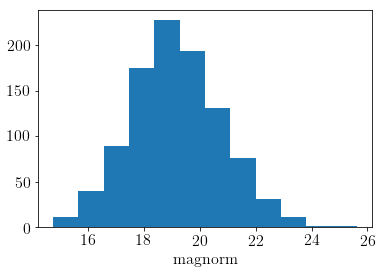

In [38]:
plt.hist(np.array(catsim_sn_match[:, 4], dtype=np.float), bins=12)
plt.xlabel('magnorm')

In [39]:
keep_df = []
for idx, twinkles_sys in enumerate(df['twinkles_sysno']):
    if twinkles_sys in keep_rows:
        #print(idx, twinkles_sys)
        keep_df.append(twinkles_sys)
    else:
        print(idx, twinkles_sys)

(95, 43)
(96, 43)
(820, 367)
(821, 367)
(850, 380)
(851, 380)
(1138, 509)
(1139, 509)
(1164, 522)
(1165, 522)
(1713, 762)
(1714, 762)
(1715, 762)
(1816, 808)
(1817, 808)
(1818, 809)
(1819, 809)
(1822, 811)
(1823, 811)
(1824, 811)
(1825, 811)
(1848, 822)
(1849, 822)
(2226, 994)
(2227, 994)


In [40]:
keep_in_df = []
for idx, twinkles_sys in enumerate(df['twinkles_sysno']):
    if twinkles_sys in keep_rows:
        #print(idx, twinkles_sys)
        keep_in_df.append(idx)
    else:
        print(idx, twinkles_sys)

(95, 43)
(96, 43)
(820, 367)
(821, 367)
(850, 380)
(851, 380)
(1138, 509)
(1139, 509)
(1164, 522)
(1165, 522)
(1713, 762)
(1714, 762)
(1715, 762)
(1816, 808)
(1817, 808)
(1818, 809)
(1819, 809)
(1822, 811)
(1823, 811)
(1824, 811)
(1825, 811)
(1848, 822)
(1849, 822)
(2226, 994)
(2227, 994)


In [41]:
catsim_z = []
catsim_m_star = []
for row in catsim_sn_match:
    catsim_z.append(np.float(row[0]))
    catsim_m_star.append(np.float(row[1]))

In [42]:
catsim_z

[0.413028001785,
 0.287957191467,
 0.545282185078,
 0.407173514366,
 0.301080107689,
 0.541866123676,
 0.293712705374,
 0.28323879838,
 0.482271105051,
 0.396558195353,
 0.344345510006,
 0.337422013283,
 0.175579994917,
 0.278105288744,
 0.228162199259,
 0.546586811543,
 0.257865488529,
 0.176175296307,
 0.567847073078,
 0.426590710878,
 0.639694273472,
 0.223783493042,
 0.242909297347,
 0.655257582664,
 0.710192978382,
 0.288484692574,
 0.257839411497,
 0.35868281126,
 0.248274892569,
 0.215078294277,
 0.21645000577,
 0.56078928709,
 0.445240706205,
 0.221965700388,
 0.333747804165,
 0.407837599516,
 0.198462605476,
 0.256455987692,
 0.557542324066,
 0.626247882843,
 0.215078294277,
 0.309692114592,
 0.215845301747,
 0.330090910196,
 0.672836124897,
 0.247996807098,
 0.439597308636,
 0.396179199219,
 0.329942494631,
 0.335380613804,
 0.545282185078,
 0.311661601067,
 0.104355297983,
 0.416697502136,
 0.333572000265,
 0.258612900972,
 0.201621204615,
 0.182239800692,
 0.50495672226,
 0

(array([  51.,  104.,  171.,  190.,  143.,  118.,   63.,   76.,   25.,
          31.,    5.,    5.]),
 array([ 0.05040373,  0.11410343,  0.17780313,  0.24150283,  0.30520253,
         0.36890223,  0.43260193,  0.49630163,  0.56000133,  0.62370104,
         0.68740074,  0.75110044,  0.81480014]),
 <a list of 12 Patch objects>)

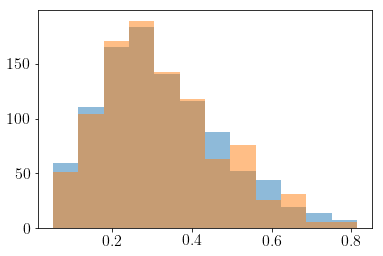

In [43]:
#Let's take a look at a couple results
n, bins, p = plt.hist(unique_df['zl'], alpha=0.5, bins=12)
plt.hist(catsim_z, alpha=0.5, bins=bins)

(array([ 173.,  383.,  204.,  115.,   54.,   27.,   16.,    9.,    0.,
           7.,    1.,    0.,    0.,    0.,    0.]),
 array([   0.        ,    6.66666667,   13.33333333,   20.        ,
          26.66666667,   33.33333333,   40.        ,   46.66666667,
          53.33333333,   60.        ,   66.66666667,   73.33333333,
          80.        ,   86.66666667,   93.33333333,  100.        ]),
 <a list of 15 Patch objects>)

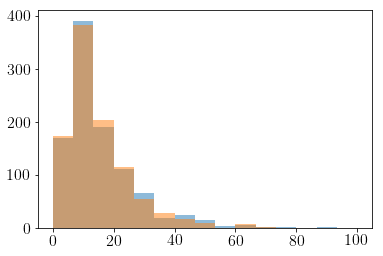

In [44]:
#Let's take a look at a couple results
n, bins, p = plt.hist(np.power(10, twinkles_log_m)/((1e10)/.73), alpha=0.5, bins=15, range=(0,100))
plt.hist(catsim_m_star, alpha=0.5, bins=bins)

As mentioned above we are able to match almost 90% of the systems, but it seems that this disproportionately leaves out high redshift lens galaxies and high masses. However, if we go to the GMM Model with 3 components we get better matching results to the CATSIM catalog.

In [30]:
# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m = np.array([])
twinkles_reff = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=3)
twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 3, x[cond_indices], model_file)
    twinkles_log_m = np.append(twinkles_log_m,log_m)

In [31]:
catsim_om10_match = []
err = 0
np.random.seed(10)
for zsrc, m_star, ellip in zip(twinkles_lenses['ZLENS'], np.power(10, twinkles_log_m)/((1e10)/.73), twinkles_lenses['ELLIP']):
    #print zsrc, m_star
    cs_results = query_catsim(db_obj, zsrc, m_star, ellip)
    try:
        catsim_om10_match.append(list(np.random.choice(cs_results)))
    except:
        err += 1
        continue
print "Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m)

Total Match Failures:  25  Percentage Match Failures:  0.0286697247706


In [32]:
catsim_z = []
catsim_m_star = []
for row in catsim_om10_match:
    catsim_z.append(row[0])
    catsim_m_star.append(row[1])

(array([  35.,   90.,  134.,  123.,  124.,   82.,   84.,   65.,   39.,
          21.,   22.,   14.,    7.,    3.,    2.]),
 array([ 0.072     ,  0.22586667,  0.37973333,  0.5336    ,  0.68746667,
         0.84133333,  0.9952    ,  1.14906667,  1.30293333,  1.4568    ,
         1.61066667,  1.76453333,  1.9184    ,  2.07226667,  2.22613333,
         2.38      ]),
 <a list of 15 Patch objects>)

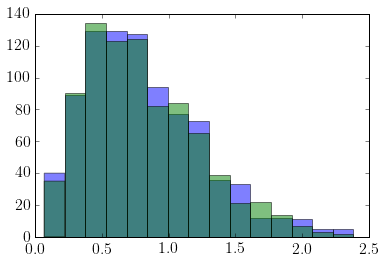

In [33]:
#Let's take a look at a couple results
n, bins, p = plt.hist(twinkles_lenses['ZLENS'], alpha=0.5, bins=15)
plt.hist(catsim_z, alpha=0.5, bins=bins)

(array([ 264.,  222.,  174.,  111.,   37.,   21.,   17.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    0.]),
 array([   0.        ,    6.66666667,   13.33333333,   20.        ,
          26.66666667,   33.33333333,   40.        ,   46.66666667,
          53.33333333,   60.        ,   66.66666667,   73.33333333,
          80.        ,   86.66666667,   93.33333333,  100.        ]),
 <a list of 15 Patch objects>)

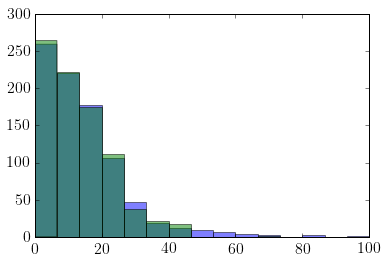

In [34]:
#Let's take a look at a couple results
n, bins, p = plt.hist(np.power(10, twinkles_log_m)/((1e10)/.73), alpha=0.5, bins=15, range=(0,100))
plt.hist(catsim_m_star, alpha=0.5, bins=bins)

The matching is now available in over 97% of the OM10 catalog and the redshift distribution matches much better. But since the distribution for the 3 component model seem to be unrealistic we see if we can get a reasonable improvement on the 1 component results using a 2 component model.

In [38]:
# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m = np.array([])
twinkles_reff = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=2)
twinkles_data = np.array([df['zl'], df['sigma']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 3, x[cond_indices], model_file)
    twinkles_log_m = np.append(twinkles_log_m,log_m)

/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Bryce/miniconda2/lib/python2.7/site-packages/sklearn/utils/depreca

In [39]:
catsim_sn_match = []
err = 0
keep_row = []
np.random.seed(10)
row = -1
for zsrc, m_star, ellip, sys_num in zip(df['zl'], np.power(10, twinkles_log_m)/((1e10)/.73), 
                                        df['theta_e'], df['twinkles_sysno']):
    if sys_num % 25 == 0:
        print(sys_num)
    row += 1
    cs_results = query_catsim(db_obj, zsrc, m_star, ellip)
    try:
        catsim_om10_match.append(list(np.random.choice(cs_results)))
        keep_row.append(row)
    except:
        err += 1
        continue
print "Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m)

0
0
25
25
50
50
75
75
100
100
125
125
150
150
175
175
200
200
225
225
250
250
250
250
275
275
300
300
325
325
350
350
375
375
375
375
400
400
400
400
425
425
450
450
475
475
500
500
525
525
550
550
575
575
600
600
600
600
625
625
650
650
675
675
700
700
725
725
750
750
775
775
800
800
825
825
850
850
875
875
900
900
925
925
950
950
975
975
Total Match Failures:  83  Percentage Match Failures:  0.0370701205895


In [47]:
catsim_z = []
catsim_m_star = []
catsim_r_eff = []
catsim_magnorm_bulge = []
catsim_sed = []
for row in catsim_sn_match:
    catsim_z.append(np.float(row[0]))
    catsim_m_star.append(np.float(row[1]))
    catsim_r_eff.append(np.sqrt(np.float(row[2])*np.float(row[3])))
    catsim_magnorm_bulge.append(np.float(row[4]))
    catsim_sed.append(row[5])

In [45]:
catsim_z = []
catsim_m_star = []
catsim_r_eff = []
catsim_magnorm_bulge = []
catsim_sed = []
results_dict = {}
for row, keep_idx in zip(catsim_sn_match, keep_rows):
    results_dict[str(keep_idx)] = row

(array([  51.,  104.,  171.,  190.,  143.,  118.,   63.,   76.,   25.,
          31.,    5.,    5.]),
 array([ 0.05040373,  0.11410343,  0.17780313,  0.24150283,  0.30520253,
         0.36890223,  0.43260193,  0.49630163,  0.56000133,  0.62370104,
         0.68740074,  0.75110044,  0.81480014]),
 <a list of 12 Patch objects>)

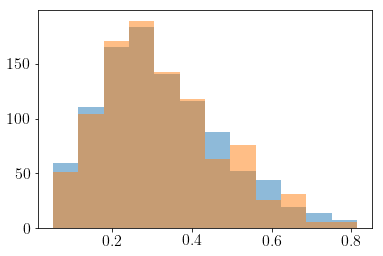

In [48]:
#Let's take a look at a couple results
n, bins, p = plt.hist(unique_df['zl'], alpha=0.5, bins=12)
plt.hist(catsim_z, alpha=0.5, bins=bins)

(array([ 173.,  383.,  204.,  115.,   54.,   27.,   16.,    9.,    0.,
           7.,    1.,    0.,    0.,    0.,    0.]),
 array([   0.        ,    6.66666667,   13.33333333,   20.        ,
          26.66666667,   33.33333333,   40.        ,   46.66666667,
          53.33333333,   60.        ,   66.66666667,   73.33333333,
          80.        ,   86.66666667,   93.33333333,  100.        ]),
 <a list of 15 Patch objects>)

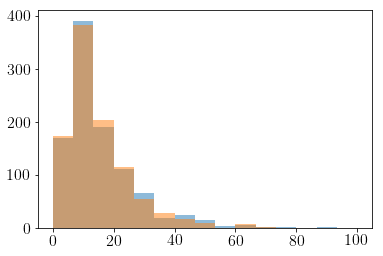

In [49]:
#Let's take a look at a couple results
n, bins, p = plt.hist(np.power(10, twinkles_log_m)/((1e10)/.73), alpha=0.5, bins=15, range=(0,100))
plt.hist(catsim_m_star, alpha=0.5, bins=bins)

Looks good on redshift and stellar mass. Also more than 98% matching within error thresholds!

## Adding new info to Twinkles SN data

We will take all the columns currently in the twinkles om10 data and add in our new reff values and also add a column with the lens galaxy SED filename.

In [50]:
len(df), len(keep_df), len(keep_rows)

(2239, 2214, 989)

In [75]:
#Scatter start dates for DC2 Run 1.1
np.random.seed(989)
t_start = np.random.uniform(59825, 59825+750, size=1000)

(array([ 111.,   87.,  102.,  101.,  105.,  103.,  105.,   98.,   97.,   91.]),
 array([ 59825.98838759,  59900.64301345,  59975.29763931,  60049.95226517,
         60124.60689103,  60199.26151689,  60273.91614275,  60348.57076861,
         60423.22539447,  60497.88002033,  60572.53464619]),
 <a list of 10 Patch objects>)

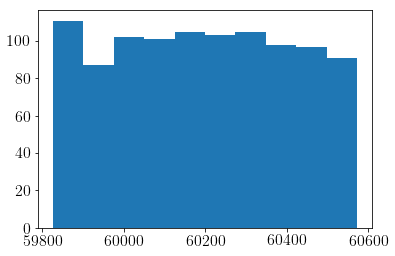

In [76]:
plt.hist(t_start)

In [65]:
catsim_z = []
catsim_m_star = []
catsim_r_eff = []
catsim_magnorm_bulge = []
catsim_sed = []
t_start_list = []
for idx in keep_df:
    row = results_dict[str(idx)]
    catsim_z.append(np.float(row[0]))
    catsim_m_star.append(np.float(row[1]))
    catsim_r_eff.append(np.sqrt(np.float(row[2])*np.float(row[3])))
    catsim_magnorm_bulge.append(np.float(row[4]))
    catsim_sed.append(row[5])
    t_start_list.append(t_start[idx])

In [66]:
final_df = df.iloc[keep_in_df]
final_df = final_df.reset_index(drop=True)

In [68]:
final_df['bulge_magnorm'] = catsim_magnorm_bulge
final_df['r_eff'] = catsim_r_eff
final_df['lens_sed'] = catsim_sed
final_df['t_start'] = np.array(t_start_list) + final_df['t0']

In [69]:
final_df

,t0,x,y,sigma,gamma,e,theta_e,theta_gamma,zs,zl,...,mag,mb,x0,x1,c,twinkles_sysno,bulge_magnorm,r_eff,lens_sed,t_start
0,0.000,0.2675,-0.4957,171.981337,0.073829,0.316210,79.160203,134.088420,0.734945,0.399013,...,22.807219,23.653111,6.275630e-06,0.0,0.0,0,20.851311,1.051339,Burst.62E09.04Z.spec,60352.338088
1,14.945,-0.1250,0.1134,171.981337,0.073829,0.316210,79.160203,134.088420,0.734945,0.399013,...,23.665449,23.653111,6.275630e-06,0.0,0.0,0,20.851311,1.051339,Burst.62E09.04Z.spec,60367.283088
2,0.000,-0.2566,-0.4932,165.882505,0.060948,0.556837,223.996858,85.495195,0.570129,0.304755,...,22.111893,22.681095,1.536256e-05,0.0,0.0,1,20.867729,0.514620,Burst.32E09.02Z.spec,60388.511317
3,11.046,-0.0276,0.1673,165.882505,0.060948,0.556837,223.996858,85.495195,0.570129,0.304755,...,22.522105,22.681095,1.536256e-05,0.0,0.0,1,20.867729,0.514620,Burst.32E09.02Z.spec,60399.557317
4,0.000,0.3682,0.4532,225.894439,0.064366,0.407094,260.542328,31.715262,0.826763,0.571931,...,23.299401,24.103708,4.143989e-06,0.0,0.0,2,19.818621,1.324775,Burst.32E09.02Z.spec,59983.159556
5,33.100,-0.2047,-0.0689,225.894439,0.064366,0.407094,260.542328,31.715262,0.826763,0.571931,...,23.888253,24.103708,4.143989e-06,0.0,0.0,2,19.818621,1.324775,Burst.32E09.02Z.spec,60016.259556
6,0.000,0.4561,-1.3810,341.766772,0.083958,0.093323,103.060178,89.996922,0.794853,0.503017,...,23.236694,24.391602,3.178782e-06,0.0,0.0,3,17.480680,2.154771,Inst.25E09.02Z.spec,60419.990722
7,118.907,-0.6168,0.4604,341.766772,0.083958,0.093323,103.060178,89.996922,0.794853,0.503017,...,23.404117,24.391602,3.178782e-06,0.0,0.0,3,17.480680,2.154771,Inst.25E09.02Z.spec,60538.897722
8,0.000,0.6177,-0.2620,181.142454,0.065735,0.132926,19.380785,340.220990,0.554654,0.297405,...,21.937435,22.825632,1.344772e-05,0.0,0.0,4,19.538691,0.618000,Burst.32E09.02Z.spec,60025.593930
9,15.622,-0.1513,0.1072,181.142454,0.065735,0.132926,19.380785,340.220990,0.554654,0.297405,...,22.921724,22.825632,1.344772e-05,0.0,0.0,4,19.538691,0.618000,Burst.32E09.02Z.spec,60041.215930


In [70]:
### Make cut for ProtoDC2 which only has galaxies up to z=1.0
redshift_cut_df = final_df.query('zs < 1.0')

In [71]:
redshift_cut_df = redshift_cut_df.reset_index(drop=True)

In [72]:
redshift_cut_df['twinkles_sysno'] += 1000

In [73]:
redshift_cut_df

,t0,x,y,sigma,gamma,e,theta_e,theta_gamma,zs,zl,...,mag,mb,x0,x1,c,twinkles_sysno,bulge_magnorm,r_eff,lens_sed,t_start
0,0.000,0.2675,-0.4957,171.981337,0.073829,0.316210,79.160203,134.088420,0.734945,0.399013,...,22.807219,23.653111,0.000006,0.0,0.0,1000,20.851311,1.051339,Burst.62E09.04Z.spec,60352.338088
1,14.945,-0.1250,0.1134,171.981337,0.073829,0.316210,79.160203,134.088420,0.734945,0.399013,...,23.665449,23.653111,0.000006,0.0,0.0,1000,20.851311,1.051339,Burst.62E09.04Z.spec,60367.283088
2,0.000,-0.2566,-0.4932,165.882505,0.060948,0.556837,223.996858,85.495195,0.570129,0.304755,...,22.111893,22.681095,0.000015,0.0,0.0,1001,20.867729,0.514620,Burst.32E09.02Z.spec,60388.511317
3,11.046,-0.0276,0.1673,165.882505,0.060948,0.556837,223.996858,85.495195,0.570129,0.304755,...,22.522105,22.681095,0.000015,0.0,0.0,1001,20.867729,0.514620,Burst.32E09.02Z.spec,60399.557317
4,0.000,0.3682,0.4532,225.894439,0.064366,0.407094,260.542328,31.715262,0.826763,0.571931,...,23.299401,24.103708,0.000004,0.0,0.0,1002,19.818621,1.324775,Burst.32E09.02Z.spec,59983.159556
5,33.100,-0.2047,-0.0689,225.894439,0.064366,0.407094,260.542328,31.715262,0.826763,0.571931,...,23.888253,24.103708,0.000004,0.0,0.0,1002,19.818621,1.324775,Burst.32E09.02Z.spec,60016.259556
6,0.000,0.4561,-1.3810,341.766772,0.083958,0.093323,103.060178,89.996922,0.794853,0.503017,...,23.236694,24.391602,0.000003,0.0,0.0,1003,17.480680,2.154771,Inst.25E09.02Z.spec,60419.990722
7,118.907,-0.6168,0.4604,341.766772,0.083958,0.093323,103.060178,89.996922,0.794853,0.503017,...,23.404117,24.391602,0.000003,0.0,0.0,1003,17.480680,2.154771,Inst.25E09.02Z.spec,60538.897722
8,0.000,0.6177,-0.2620,181.142454,0.065735,0.132926,19.380785,340.220990,0.554654,0.297405,...,21.937435,22.825632,0.000013,0.0,0.0,1004,19.538691,0.618000,Burst.32E09.02Z.spec,60025.593930
9,15.622,-0.1513,0.1072,181.142454,0.065735,0.132926,19.380785,340.220990,0.554654,0.297405,...,22.921724,22.825632,0.000013,0.0,0.0,1004,19.538691,0.618000,Burst.32E09.02Z.spec,60041.215930


In [74]:
redshift_cut_df.to_csv('../../data/dc2_sne_cat.csv')

Looks good!